<a href="https://colab.research.google.com/github/shiva-lab/Walmart-M5_AccuracyPrediction/blob/master/Sequence2SequenceModel_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn import preprocessing, metrics
from ipywidgets import widgets, interactive
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta 
from typing import Union
from tqdm.notebook import tqdm_notebook as tqdm
from itertools import cycle
import datetime as dt
from torch.autograd import Variable
import random 
import os
from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import time 
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.metrics import mean_squared_error
import torch 
from sklearn.model_selection import TimeSeriesSplit

from math import log
from math import exp
from scipy.stats import boxcox

 
import torch.optim as optim

%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
calendar_df= pd.read_csv('/content/gdrive/My Drive/Kaggle/calendar.csv')
sell_prices_df= pd.read_csv('/content/gdrive/My Drive/Kaggle/sell_prices.csv')
#sales_train_evaluation= pd.read_csv('/content/gdrive/My Drive/Kaggle/sales_train_evaluation.csv')
sales_train_validation_df=pd.read_csv('/content/gdrive/My Drive/Kaggle/sales_train_validation.csv')

In [ ]:
pd.set_option('max_columns', 50)
plt.style.use('bmh')
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device is:",device)

device is: cuda


In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df




In [ ]:
 sell_prices_df = reduce_mem_usage(sell_prices_df)
 print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))
calendar_df = reduce_mem_usage(calendar_df)
print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))
sales_train_validation_df= reduce_mem_usage(sales_train_validation_df)
print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))


Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Mem. usage decreased to 95.00 Mb (78.7% reduction)
Sales train validation has 30490 rows and 1919 columns


In [ ]:
#Create date index,creation of date_list will be used later to show time series with right dates
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

One time Series example

In [ ]:
# Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
DF_Sales.columns = sales_train_validation_df['item_store_id'].values

#Set Dates as index 
DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index)

DF_Sales.head()

,HOBBIES_1_001_CA_1,HOBBIES_1_002_CA_1,HOBBIES_1_003_CA_1,HOBBIES_1_004_CA_1,HOBBIES_1_005_CA_1,HOBBIES_1_006_CA_1,HOBBIES_1_007_CA_1,HOBBIES_1_008_CA_1,HOBBIES_1_009_CA_1,HOBBIES_1_010_CA_1,HOBBIES_1_011_CA_1,HOBBIES_1_012_CA_1,HOBBIES_1_013_CA_1,HOBBIES_1_014_CA_1,HOBBIES_1_015_CA_1,HOBBIES_1_016_CA_1,HOBBIES_1_017_CA_1,HOBBIES_1_018_CA_1,HOBBIES_1_019_CA_1,HOBBIES_1_020_CA_1,HOBBIES_1_021_CA_1,HOBBIES_1_022_CA_1,HOBBIES_1_023_CA_1,HOBBIES_1_024_CA_1,HOBBIES_1_025_CA_1,HOBBIES_1_026_CA_1,HOBBIES_1_027_CA_1,HOBBIES_1_028_CA_1,HOBBIES_1_029_CA_1,HOBBIES_1_030_CA_1,HOBBIES_1_031_CA_1,HOBBIES_1_032_CA_1,HOBBIES_1_033_CA_1,HOBBIES_1_034_CA_1,HOBBIES_1_035_CA_1,HOBBIES_1_036_CA_1,HOBBIES_1_037_CA_1,HOBBIES_1_038_CA_1,HOBBIES_1_039_CA_1,HOBBIES_1_040_CA_1,HOBBIES_1_041_CA_1,HOBBIES_1_042_CA_1,HOBBIES_1_043_CA_1,HOBBIES_1_044_CA_1,HOBBIES_1_045_CA_1,HOBBIES_1_046_CA_1,HOBBIES_1_047_CA_1,HOBBIES_1_048_CA_1,HOBBIES_1_049_CA_1,HOBBIES_1_050_CA_1,HOBBIES_1_051_CA_1,HOBBIES_1_052_CA_1,HOBBIES_1_053_CA_1,HOBBIES_1_054_CA_1,HOBBIES_1_055_CA_1,HOBBIES_1_056_CA_1,HOBBIES_1_057_CA_1,HOBBIES_1_058_CA_1,HOBBIES_1_060_CA_1,HOBBIES_1_061_CA_1,HOBBIES_1_062_CA_1,HOBBIES_1_063_CA_1,HOBBIES_1_064_CA_1,HOBBIES_1_065_CA_1,HOBBIES_1_066_CA_1,HOBBIES_1_067_CA_1,HOBBIES_1_068_CA_1,HOBBIES_1_069_CA_1,HOBBIES_1_070_CA_1,HOBBIES_1_072_CA_1,HOBBIES_1_073_CA_1,HOBBIES_1_074_CA_1,HOBBIES_1_075_CA_1,HOBBIES_1_076_CA_1,HOBBIES_1_077_CA_1,HOBBIES_1_078_CA_1,HOBBIES_1_079_CA_1,HOBBIES_1_080_CA_1,HOBBIES_1_081_CA_1,HOBBIES_1_082_CA_1,HOBBIES_1_083_CA_1,HOBBIES_1_084_CA_1,HOBBIES_1_085_CA_1,HOBBIES_1_086_CA_1,HOBBIES_1_087_CA_1,HOBBIES_1_088_CA_1,HOBBIES_1_089_CA_1,HOBBIES_1_090_CA_1,HOBBIES_1_091_CA_1,HOBBIES_1_092_CA_1,HOBBIES_1_093_CA_1,HOBBIES_1_094_CA_1,HOBBIES_1_095_CA_1,HOBBIES_1_097_CA_1,HOBBIES_1_098_CA_1,HOBBIES_1_099_CA_1,HOBBIES_1_100_CA_1,HOBBIES_1_102_CA_1,HOBBIES_1_103_CA_1,HOBBIES_1_104_CA_1,HOBBIES_1_105_CA_1,HOBBIES_1_106_CA_1,HOBBIES_1_107_CA_1,HOBBIES_1_108_CA_1,HOBBIES_1_109_CA_1,HOBBIES_1_110_CA_1,HOBBIES_1_111_CA_1,HOBBIES_1_112_CA_1,HOBBIES_1_113_CA_1,HOBBIES_1_114_CA_1,HOBBIES_1_115_CA_1,HOBBIES_1_116_CA_1,HOBBIES_1_117_CA_1,HOBBIES_1_118_CA_1,HOBBIES_1_119_CA_1,HOBBIES_1_120_CA_1,HOBBIES_1_121_CA_1,HOBBIES_1_122_CA_1,HOBBIES_1_123_CA_1,HOBBIES_1_124_CA_1,HOBBIES_1_125_CA_1,HOBBIES_1_126_CA_1,HOBBIES_1_127_CA_1,HOBBIES_1_128_CA_1,HOBBIES_1_129_CA_1,HOBBIES_1_130_CA_1,HOBBIES_1_131_CA_1,HOBBIES_1_132_CA_1,HOBBIES_1_133_CA_1,HOBBIES_1_134_CA_1,HOBBIES_1_135_CA_1,HOBBIES_1_136_CA_1,HOBBIES_1_137_CA_1,HOBBIES_1_138_CA_1,HOBBIES_1_139_CA_1,HOBBIES_1_140_CA_1,HOBBIES_1_141_CA_1,HOBBIES_1_142_CA_1,HOBBIES_1_143_CA_1,HOBBIES_1_144_CA_1,HOBBIES_1_145_CA_1,HOBBIES_1_146_CA_1,HOBBIES_1_147_CA_1,HOBBIES_1_148_CA_1,HOBBIES_1_149_CA_1,HOBBIES_1_150_CA_1,HOBBIES_1_151_CA_1,HOBBIES_1_152_CA_1,HOBBIES_1_153_CA_1,HOBBIES_1_154_CA_1,HOBBIES_1_155_CA_1,HOBBIES_1_156_CA_1,HOBBIES_1_157_CA_1,HOBBIES_1_158_CA_1,HOBBIES_1_159_CA_1,HOBBIES_1_160_CA_1,HOBBIES_1_161_CA_1,HOBBIES_1_162_CA_1,HOBBIES_1_163_CA_1,HOBBIES_1_164_CA_1,HOBBIES_1_165_CA_1,HOBBIES_1_166_CA_1,HOBBIES_1_167_CA_1,HOBBIES_1_168_CA_1,HOBBIES_1_169_CA_1,HOBBIES_1_170_CA_1,HOBBIES_1_171_CA_1,HOBBIES_1_172_CA_1,HOBBIES_1_173_CA_1,HOBBIES_1_174_CA_1,HOBBIES_1_175_CA_1,HOBBIES_1_176_CA_1,HOBBIES_1_177_CA_1,HOBBIES_1_178_CA_1,HOBBIES_1_179_CA_1,HOBBIES_1_180_CA_1,HOBBIES_1_181_CA_1,HOBBIES_1_183_CA_1,HOBBIES_1_184_CA_1,HOBBIES_1_185_CA_1,HOBBIES_1_186_CA_1,HOBBIES_1_187_CA_1,HOBBIES_1_188_CA_1,HOBBIES_1_189_CA_1,HOBBIES_1_190_CA_1,HOBBIES_1_191_CA_1,HOBBIES_1_192_CA_1,HOBBIES_1_193_CA_1,HOBBIES_1_194_CA_1,HOBBIES_1_195_CA_1,HOBBIES_1_197_CA_1,HOBBIES_1_198_CA_1,HOBBIES_1_199_CA_1,HOBBIES_1_200_CA_1,HOBBIES_1_201_CA_1,HOBBIES_1_202_CA_1,HOBBIES_1_203_CA_1,HOBBIES_1_204_CA_1,HOBBIES_1_205_CA_1,HOBBIES_1_206_CA_1,HOBBIES_1_207_CA_1,HOBBIES_1_208_CA_1,HOBBIES_1_209_CA_1,HOBBIES_1_210_CA_1,HOBBIES_1_211_CA_1,HOBBIES_1_212_CA_1,HOBBIES_1_213_CA_1,HOBBIES_1_214_CA_1,HOBBIES_1_215_CA_1,HOBBIES_1_216_CA_1,HOBBIES_1

visualization

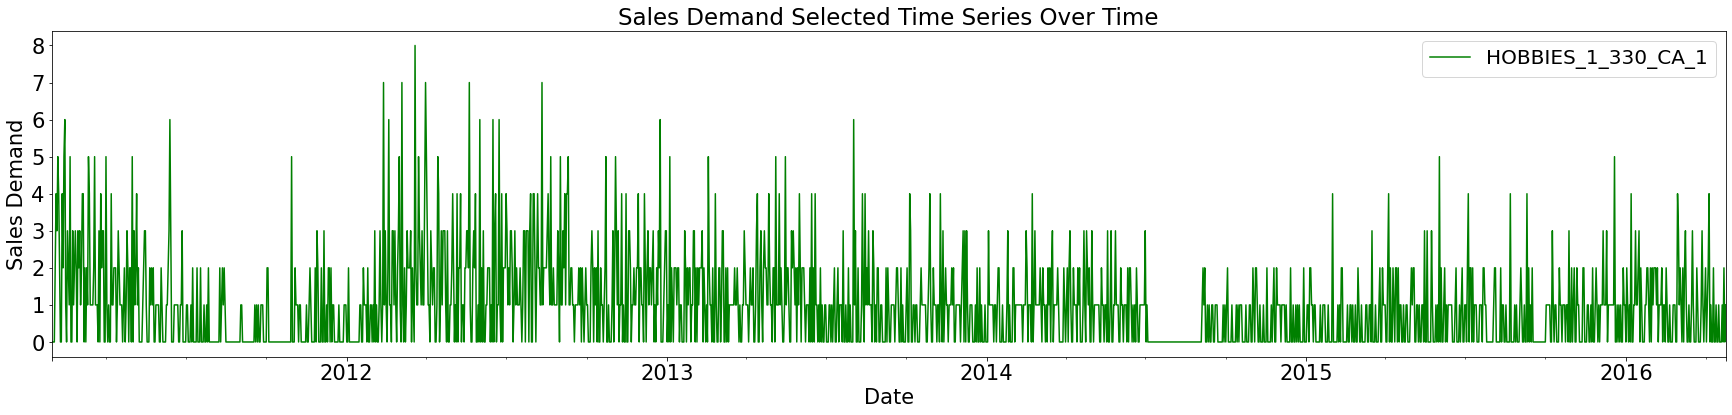

In [ ]:
#Select random index and plot the time series
index = 321
y = pd.DataFrame(DF_Sales.iloc[:,index])
TS_selected = y 
y = pd.DataFrame(y).set_index([dates_list])
y.index = pd.to_datetime(y.index)
ax = y.plot(figsize=(30, 6),color='green')
#ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

as per fig we can see there are some days in 2012 and period between 2014 and 2015 where sales was considerably down

In [ ]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

Im using all data except for last 28 days which will be used as test data  and all data except from the last 28 days as training data

In [ ]:
train_size = int((len(TS_selected)-28) * 0.67) #67% as training data
valid_size = (len(TS_selected)-28)- train_size
print("train size is:",train_size)
print("validation size is:",valid_size)

train size is: 1262
validation size is: 623


In [ ]:
train_data = TS_selected.iloc[0:train_size,:]
valid_data = TS_selected.iloc[train_size:train_size+valid_size,:]
print("train data shape is:",train_data.shape)
print("validation data shape is:",valid_data.shape)

train data shape is: (1262, 1)
validation data shape is: (623, 1)


In [ ]:
train_data.head()

,HOBBIES_1_330_CA_1
2011-01-29,0
2011-01-30,0
2011-01-31,0
2011-02-01,0
2011-02-02,2


# Difference transform

A difference transform is a simple way for removing a systematic structure from the time series.


In [ ]:
# Simple Difference transform  --> X(t)' = X(t) - X(t-7)
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

np_tarin_data = train_data.iloc[:,0]
interval = 7 
transformed_train = difference(np_tarin_data, interval)

np_valid_data = valid_data.iloc[:,0]
interval = 7 
transformed_valid = difference(np_valid_data, interval)

train_data = np.array(transformed_train).reshape(len(transformed_train),1)
valid_data = np.array(transformed_valid).reshape(len(transformed_valid),1)

In [ ]:
train_data.shape

(1255, 1)

In [ ]:
valid_data.shape

(616, 1)

# Noormalize: min/max scaler

Scale or Normalization is a technique often applied as part of data preparation for machine learning. The goal of normalization is to change the values of numeric columns in the dataset to use a common scale, without distorting differences in the ranges of values. For machine learning, every dataset does not require normalization. It is required only when features have different rangesor scales.

Normalizes our data using the min/max scaler with minimum and maximum values of -1 and 1, respectively

In [ ]:
#Normalize data using the min/max scaler with minimum and maximum values of -1 and 1, respectively
scaler = MinMaxScaler((-1,1)).fit(train_data)
#scaler = StandardScaler().fit(train_data)
train_data_std = scaler.transform(train_data)
valid_data_std = scaler.transform(valid_data)

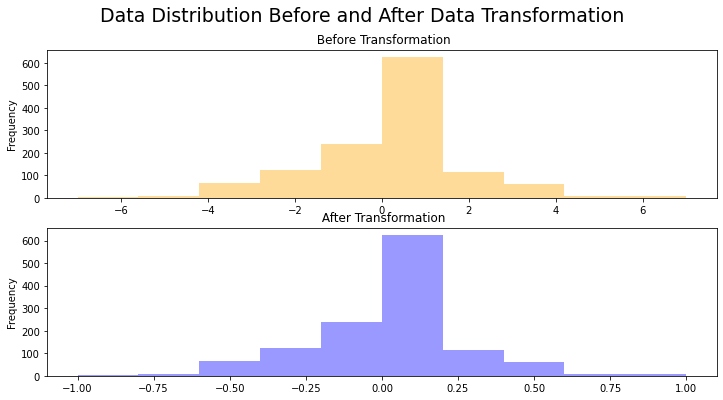

In [ ]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Data Transformation   ',fontsize = 19)
pd.DataFrame(train_data).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], legend = False,title = ' Before Transformation',color ='orange') 
pd.DataFrame(train_data_std).plot(kind='hist', ax = axs[1] ,figsize=[12,6], alpha=.4 , legend = False,title = ' After Transformation'\
                                         ,color = 'blue')

**Another way of normalization**

In [ ]:
def sliding_windows(data, seq_length,labels_length):
    x = []
    y = []

    for i in range(len(data)-(seq_length+labels_length)):
        _x = data[i:(i+seq_length)]
        _y = data[(i+seq_length):(i+seq_length+labels_length)]
        x.append(_x)
        y.append(_y)

    return x,y

I wil use a sliding window of 90 days Our target(labels) is 28 days

In [ ]:
seq_length = 90 #90 days sliding window
labels_length =28 #target label
train_X, train_y = sliding_windows(train_data_std, seq_length,labels_length)
print("train X  has:", len(train_X) , "series")
print("train labels  has:", len(train_y) , "series")
valid_X, valid_y = sliding_windows(valid_data_std, seq_length,labels_length)
print("validiation  X  has:", len(valid_X) , "series")
print("Validiation  labels  has:" ,len(valid_y) , "series")

train X  has: 1137 series
train labels  has: 1137 series
validiation  X  has: 498 series
Validiation  labels  has: 498 series


Plot Example:
To verify the concept Let's plot

The original TS (take the length of the sliding window + the label size - 90 days + 28 days)
The first array of trainX - which is the first sequence
The first array of trainy , which is the first label

(-1.0, 1.0)

<Figure size 1080x1224 with 0 Axes>

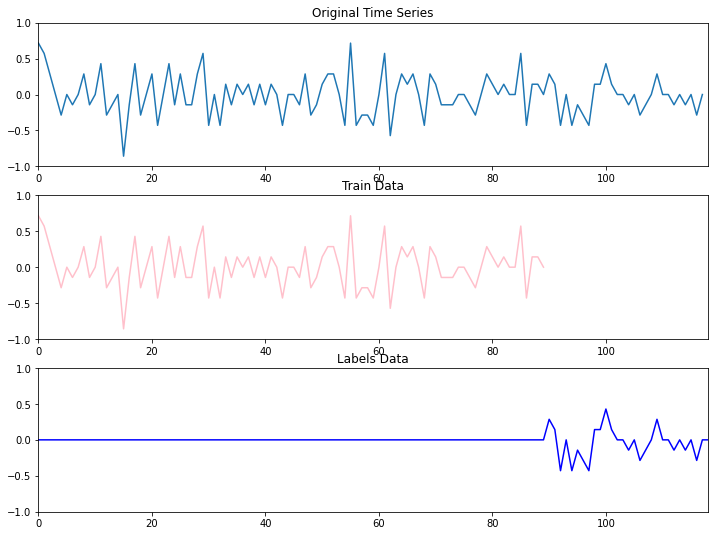

In [ ]:
plt.figure(figsize=(15,17))
fig, axs =plt.subplots(3,figsize=(12,9))

axs[0].plot(train_data_std[0:seq_length+labels_length])
axs[0].title.set_text('Original Time Series')
axs[0].set_xlim(0,seq_length+labels_length)
axs[0].set_ylim(-1,1)
axs[1].plot(train_X[0].flatten(),color="pink")
axs[1].title.set_text('Train Data')
axs[1].set_xlim(0,seq_length+labels_length)
axs[1].set_ylim(-1,1)
axs[2].plot(np.pad(train_y[0].flatten(),seq_length),color='blue')
axs[2].title.set_text('Labels Data')
axs[2].set_xlim(0,seq_length+labels_length)
axs[2].set_ylim(-1,1)

[Pytorch tensor read-up](https://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html)

In [ ]:
trainX = Variable(torch.Tensor(train_X))
trainy = Variable(torch.Tensor(train_y))

validX = Variable(torch.Tensor(valid_X))
validy= Variable(torch.Tensor(valid_y))

print ("trainX shape is:",trainX.size())
print ("trainy shape is:",trainy.size())
print ("validX shape is:",validX.size())
print ("validy shape is:",validy.size())

trainX shape is: torch.Size([1137, 90, 1])
trainy shape is: torch.Size([1137, 28, 1])
validX shape is: torch.Size([498, 90, 1])
validy shape is: torch.Size([498, 28, 1])


Building sequence to sequence model

The Encoder structure is very similar to an LSTM/RNN network for sequence modeling/training.

The difference is that we output the Hidden and Cell states of the last cell, as an output to feed it to the decoder.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))
        
        
        #return hidden_n.reshape((self.n_features, self.embedding_dim))
        return x, hidden , cell 

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim ) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[0]
        src_len = encoder_outputs.shape[1]
        
       
        hidden = hidden[2:3,:,:]
        
        #print("hidden size is",hidden.size())
        
        
        
        #repeat decoder hidden state src_len times
        #hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        hidden = hidden.repeat(1, src_len, 1)
     
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #print("encode_outputs size after permute is:",encoder_outputs.size())
        
        
        #hidden = [batch size, src len, dec hid dim]
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src len, dec hid dim]

        attention = self.v(energy).squeeze(2)
        
        #attention= [batch size, src len]
        
        
        return F.softmax(attention, dim=1)

Decoder:

 predict using the first cell, and then iterate (using our prediction)
  to create overall of 28 TS samples


In [ ]:
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=1,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x,input_hidden,input_cell):
       
       
        x = x.reshape((1,1,1))
        
        
     

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n


In [ ]:
class AttentionDecoder(nn.Module):
    def __init__(self, seq_len,attention, input_dim=64, n_features=1,encoder_hidden_state = 512):
        super(AttentionDecoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        self.attention = attention 
        
        self.rnn1 = nn.LSTM(
          #input_size=1,
          input_size= encoder_hidden_state + 1,  # Encoder Hidden State + One Previous input
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim * 2 , n_features)

    def forward(self, x,input_hidden,input_cell,encoder_outputs):
       
        a = self.attention(input_hidden, encoder_outputs)
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src len]
        
        #encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src len, enc hid dim * 2]
        
      
        
        weighted = torch.bmm(a, encoder_outputs)
        
        
     
        x = x.reshape((1,1,1))
       
        
        
        rnn_input = torch.cat((x, weighted), dim = 2)
       

        #x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
        x, (hidden_n, cell_n) = self.rnn1(rnn_input,(input_hidden,input_cell))
        
        output = x.squeeze(0)
        weighted = weighted.squeeze(0)
        
        x = self.output_layer(torch.cat((output, weighted), dim = 1))
        return x, hidden_n, cell_n
    

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 28):
        super(Seq2Seq, self).__init__()

        
        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.attention = Attention(512,512)
        self.output_length = output_length
        self.decoder = AttentionDecoder(seq_len, self.attention, embedding_dim, n_features).to(device)
        

    def forward(self,x, prev_y):
        
        encoder_output,hidden,cell = self.encoder(x)
         
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        prev_output = prev_y
        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
        
            prev_x,prev_hidden,prev_cell = self.decoder(prev_output,hidden,cell,encoder_output)
            hidden,cell = prev_hidden,prev_cell
            prev_output = prev_x
            
            targets_ta.append(prev_x.reshape(1))
           
            
        targets = torch.stack(targets_ta)
        return targets


In [ ]:
n_features = 1
model = Seq2Seq(seq_length, n_features, 512)
model = model.to(device)

In [ ]:
model

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (attention): Attention(
    (attn): Linear(in_features=1024, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (decoder): AttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (rnn1): LSTM(513, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(1, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (attention): Attention(
    (attn): Linear(in_features=1024, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=False)
  )
  (decoder): AttentionDecoder(
    (attention): Attention(
      (attn): Linear(in_features=1024, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (rnn1): LSTM(513, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=1024, out_features=1, bias=True)
  )
)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3,weight_decay=1e-5)
criterion = torch.nn.MSELoss().to(device) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)


In [ ]:
def train_model(model, TrainX,Trainy,ValidX,Validy,seq_length, n_epochs):
  
    history = dict(train=[], val=[])

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    mb = master_bar(range(1, n_epochs + 1))

    for epoch in mb:
        model = model.train()

        train_losses = []
        for i in progress_bar(range(TrainX.size()[0]),parent=mb):
            seq_inp = TrainX[i,:,:].to(device)
            seq_true = Trainy[i,:,:].to(device)
           
            optimizer.zero_grad()

            
            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])
            
            
            loss = criterion(seq_pred, seq_true)

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for i in progress_bar(range(validX.size()[0]),parent=mb):
                seq_inp = ValidX[i,:,:].to(device)
                seq_true = Validy[i,:,:].to(device)
        
                seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])
               

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        scheduler.step()
    #model.load_state_dict(best_model_wts)
    return model.eval(), history

In [ ]:
model, history = train_model(
  model,
  trainX,trainy,
  validX,validy,
  seq_length,
  n_epochs=15, ## Training only on 30 epochs to save GPU time 
    
)

saved best model epoch: 1 val loss is: 0.0370509890861899
Epoch 1: train loss 0.0650494398455821 val loss 0.0370509890861899
saved best model epoch: 2 val loss is: 0.035810181697134874
Epoch 2: train loss 0.06056086170645193 val loss 0.035810181697134874
Epoch 3: train loss 0.056897675368087916 val loss 0.03749113891976904
Epoch 4: train loss 0.17314538806668672 val loss 0.041146550361201704
Epoch 5: train loss 0.05778825229399149 val loss 0.038687057262024725
Epoch 6: train loss 0.05723161405655199 val loss 0.03844079928263184
Epoch 7: train loss 0.05709499038515077 val loss 0.037472473895065035
Epoch 8: train loss 0.057158909767142045 val loss 0.03642109230190635
Epoch 9: train loss 0.05720113911223659 val loss 0.037478881716040004
Epoch 10: train loss 0.05687060895053999 val loss 0.03669366996593205
Epoch 11: train loss 0.05684823357592695 val loss 0.03795766952563541
Epoch 12: train loss 0.05923945598694166 val loss 0.036057543538765134
Epoch 13: train loss 0.05672638916976507 val 

**Predict:**

 take, the last 28 days available as our target for prediction and the previous 90 days as the input to the model We take it from the original series, and we need to issue the transformation again

In [ ]:
TestX = np.array(TS_selected.iloc[-118:-28:,:])
Testy = np.array(TS_selected.iloc[-28:,:])
TestX = Variable(torch.Tensor(TestX))
 

In [ ]:
#Diff transform
TestX_Diff = difference(TestX, interval)
TestX_Diff_Norm = scaler.transform(np.array(TestX_Diff).reshape(len(TestX_Diff),1))

In [ ]:
####Prediction
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

with torch.no_grad():
    seq_inp = TestX.to(device)
    
        
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:])

In [ ]:
data_predict = scaler.inverse_transform(seq_pred.cpu().numpy())
labels = Testy

**Inverse Difference transform**

conctnate the original 90 days (input) to the prediction (which is in diff transform domain) 

In [ ]:
orignal_data = np.array(TS_selected.iloc[-118:-28:,:]).flatten()
pred = data_predict.flatten()
orig_pred = np.concatenate([orignal_data,pred])

In [ ]:
time_diff = 7 
inv_pred = np.zeros((28))
for  index in range(28):
    inv_pred[index] = orig_pred[90+index]+ orig_pred[90+index-7]
    orig_pred[90+index] = inv_pred[index]

In [ ]:
data_predict= np.array(inv_pred)
data_predict = np.where(data_predict<0,0,data_predict)

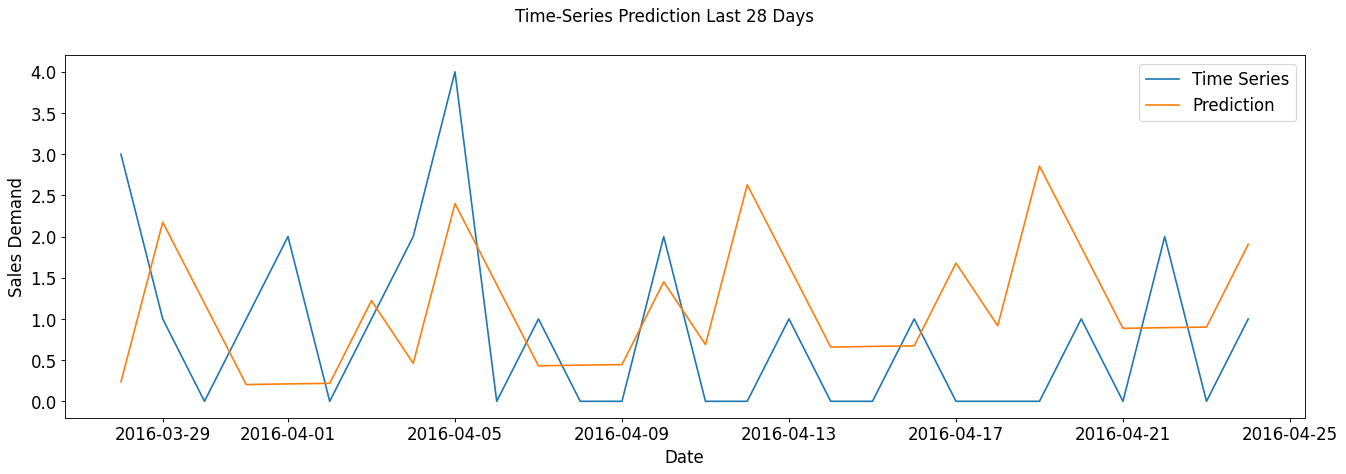

In [ ]:
## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[-28:]])
df_labels = pd.DataFrame(labels)
df_labels = df_labels.set_index([dates_list[-28:]])

# Plot 
figure(num=None, figsize=(20, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series','Prediction'],fontsize = 15)
plt.suptitle('Time-Series Prediction Last 28 Days',fontsize = 15)
plt.xticks(fontsize=15 )
plt.yticks(fontsize=15 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 15)
plt.xlabel(xlabel = 'Date',fontsize = 15)
plt.show()

**RMSE**

In [ ]:
np.sqrt(((data_predict - labels) ** 2).mean())

1.3190864357436887

**Add Features**
So far we add only one feature - The Sales demand Now let's more features We will add more dimension to the input and we will feed it both to the Encoder and the decoder

Features can be lags or rolling windows It is easier to implement using data-frame Lag is just shifting the sales demand.

Rolling window is some calculation over a window (example mean , std )

To do the manipulation and add the features it is easier to work with a pandas Data frame So we will return our Selected time series into a data frame.

In [ ]:
DF = TS_selected
colnames = DF.columns
DF = DF.rename(columns={colnames[0]:'sales'})
DF.tail()

,sales
2016-04-20,1
2016-04-21,0
2016-04-22,2
2016-04-23,0
2016-04-24,1


**Transformation**

In [ ]:
## Simple Difference transform  --> X(t)' = X(t) - X(t-7)

def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

transformed_data = difference(DF['sales'], interval)
DF = DF.iloc[7:,:]
DF['orig_sales'] = DF['sales']
DF['sales'] = transformed_data
DF.shape

(1906, 2)

In [ ]:
start_time = time.time()
for i in (1,7,14,28,365):
    print('Shifting:', i)
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))

Shifting: 1
Shifting: 7
Shifting: 14
Shifting: 28
Shifting: 365
0.00 min: Time for bulk shift


In [ ]:
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    DF['rolling_mean_'+str(i)] = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    DF['rolling_std_'+str(i)]  = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).std())


print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))
DF.head()

Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 60
Rolling period: 180
Rolling period: 365
0.41 min: Time for loop


,sales,orig_sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-02-05,5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-06,4,4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-07,2,2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-08,0,0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-02-09,-2,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
DF = DF.replace('nan', np.nan).fillna(0)
DF.head()

,sales,orig_sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-02-05,5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-06,4,4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-07,2,2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-08,0,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-09,-2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalize

In [ ]:
DF = DF.drop('orig_sales',1)
DF_normlized = DF.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(DF) 
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))
DF_normlized.iloc[:,:] =  scaled_data
   

DF_normlized.head()

,sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
2011-02-05,0.714286,0.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-06,0.571429,0.714286,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-07,0.285714,0.571429,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-08,0.000000,0.285714,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2011-02-09,-0.285714,0.000000,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0



**Split Data**

Again We will split the data into a training set and a validation set
We will use all data except from the last 28 days as train and validation The last 28 days will be used for tests data



In [ ]:
train_size = int((DF_normlized.shape[0]-28) * 0.67)
valid_size = (DF_normlized.shape[0]-28)- train_size
print("train size is:",train_size)
print("validation size is:",valid_size)
train_data = DF_normlized.iloc[0:train_size,:]
valid_data = DF_normlized.iloc[train_size:train_size+valid_size,:]
print("train data shape is:",train_data.shape)
print("validation data shape is:",valid_data.shape)

train size is: 1258
validation size is: 620
train data shape is: (1258, 18)
validation data shape is: (620, 18)


**Multi-Dimensional Sliding Window**

In [ ]:
###  This function creates a sliding window or sequences of seq_length days and labels_length  days label ####
def sliding_windows(data, seq_length,labels_length):
    x = []
    y = []
    z = []

    for i in range(len(data)-(seq_length+labels_length)):
        _x = data.iloc[i:(i+seq_length),:]
        _y = data.iloc[(i+seq_length):(i+seq_length+labels_length),0:1]
        _z  = data.iloc[(i+seq_length):(i+seq_length+labels_length),1:]
        x.append(np.array(_x))
        y.append(np.array(_y))
        z.append(np.array(_z))

    return x,y,z

We wil use a sliding window of 90 days Our target(labels) is 28 days

In [ ]:
seq_length = 90
labels_length =28
train_X, train_y,train_features = sliding_windows(train_data, seq_length,labels_length)
print("train X  has:", len(train_X) , "series")
print("train labels  has:", len(train_y) , "series")
valid_X, valid_y,valid_features = sliding_windows(valid_data, seq_length,labels_length)
print("validiation  X  has:", len(valid_X) , "series")
print("Validiation  labels  has:" ,len(valid_y) , "series")

train X  has: 1140 series
train labels  has: 1140 series
validiation  X  has: 502 series
Validiation  labels  has: 502 series


In [ ]:
train_X[0].shape

(90, 18)

In [ ]:
train_y[0].shape

(28, 1)

In [ ]:
train_features[0].shape

(28, 17)

In [ ]:
trainX = Variable(torch.Tensor(train_X))
trainy = Variable(torch.Tensor(train_y))
train_features = Variable(torch.Tensor(train_features))
validX = Variable(torch.Tensor(valid_X))
validy= Variable(torch.Tensor(valid_y))
valid_features = Variable(torch.Tensor(valid_features))


print ("trainX shape is:",trainX.size())
print ("trainy shape is:",trainy.size())
print ("train features  shape is:",train_features.size())
print ("validX shape is:",validX.size())
print ("validy shape is:",validy.size())
print ("valid features  shape is:",valid_features.size())

trainX shape is: torch.Size([1140, 90, 18])
trainy shape is: torch.Size([1140, 28, 1])
train features  shape is: torch.Size([1140, 28, 17])
validX shape is: torch.Size([502, 90, 18])
validy shape is: torch.Size([502, 28, 1])
valid features  shape is: torch.Size([502, 28, 17])


**Seq2Seq Model**

The model needs to be adjusted The main difference is that the decoder input is also fed with the N features (except the previous prediction)



**Encoder**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()

        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim,  embedding_dim
        self.num_layers = 3
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
   
    def forward(self, x):
       
        x = x.reshape((1, self.seq_len, self.n_features))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_dim).to(device))
              
        x, (hidden, cell) = self.rnn1(x,(h_1, c_1))

        #return hidden_n.reshape((self.n_features, self.embedding_dim))
        return hidden , cell 

**Decoder**

In [ ]:
   
class Decoder(nn.Module):    
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()

        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features =  input_dim, n_features
        
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=input_dim,
          num_layers=3,
          batch_first=True,
          dropout = 0.35
        )
        
        
      
        self.output_layer = nn.Linear(self.hidden_dim, n_features)

    def forward(self, x,input_hidden,input_cell):
       
       
        x = x.reshape((1,1,self.n_features ))
        #print("decode input",x.size())
             

        x, (hidden_n, cell_n) = self.rnn1(x,(input_hidden,input_cell))
    
        x = self.output_layer(x)
        return x, hidden_n, cell_n

In [ ]:
class Seq2Seq(nn.Module):

    def __init__(self, seq_len, n_features, embedding_dim=64,output_length = 28):
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
        self.n_features = n_features
        self.output_length = output_length
        self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
        

    def forward(self,x, prev_y,features):
        
       
        hidden,cell = self.encoder(x)
         
        #Prepare place holder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        dec_input = prev_y
        
        
        
       #dec_input = torch.cat([prev_output, curr_features], dim=1) 
        
        #itearate over LSTM - according to the required output days
        for out_days in range(self.output_length) :
            
          
            prev_x,prev_hidden,prev_cell = self.decoder(dec_input,hidden,cell)
            hidden,cell = prev_hidden,prev_cell
            
            prev_x = prev_x[:,:,0:1]
            #print("preve x shape is:",prev_x.size())
            #print("features shape is:",features[out_days+1].size())
            
            if out_days+1 < self.output_length :
                dec_input = torch.cat([prev_x,features[out_days+1].reshape(1,1,17)], dim=2) 
            
            targets_ta.append(prev_x.reshape(1))
           
            
        
        
        targets = torch.stack(targets_ta)

        return targets

In [ ]:
n_features = trainX.shape[2]
model = Seq2Seq(seq_length, n_features, 512)
model = model.to(device)
model

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(18, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (decoder): Decoder(
    (rnn1): LSTM(18, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=512, out_features=18, bias=True)
  )
)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (rnn1): LSTM(18, 512, num_layers=3, batch_first=True, dropout=0.35)
  )
  (decoder): Decoder(
    (rnn1): LSTM(18, 512, num_layers=3, batch_first=True, dropout=0.35)
    (output_layer): Linear(in_features=512, out_features=18, bias=True)
  )
)

In [ ]:
def train_model(model, TrainX,Trainy,ValidX,Validy,seq_length, n_epochs):
  
    history = dict(train=[], val=[])

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 10000.0
    mb = master_bar(range(1, n_epochs + 1))

    for epoch in mb:
        model = model.train()

        train_losses = []
        for i in progress_bar(range(TrainX.size()[0]),parent=mb):
            seq_inp = TrainX[i,:,:].to(device)
            seq_true = Trainy[i,:,:].to(device)
            features = train_features[i,:,:].to(device)
           
            optimizer.zero_grad()

            
            seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
            
            
            loss = criterion(seq_pred, seq_true)

            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()

            train_losses.append(loss.item())

        val_losses = []
        model = model.eval()
        with torch.no_grad():
            for i in progress_bar(range(validX.size()[0]),parent=mb):
                seq_inp = ValidX[i,:,:].to(device)
                seq_true = Validy[i,:,:].to(device)
                features = valid_features[i,:,:].to(device)
        
                seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],features)
               

                loss = criterion(seq_pred, seq_true)
                val_losses.append(loss.item())

        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_model_n_features.pt')
            print("saved best model epoch:",epoch,"val loss is:",val_loss)
        
        print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
        scheduler.step(val_loss)
    #model.load_state_dict(best_model_wts)
    return model.eval(), history


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2,weight_decay=1e-5)
criterion = torch.nn.MSELoss().to(device) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=10, factor =0.5 ,min_lr=1e-7, eps=1e-08)

In [ ]:
model, history = train_model(
  model,
  trainX,trainy,
  validX,validy,
  seq_length,
  n_epochs=10,  
    
)


saved best model epoch: 1 val loss is: 0.03570390121447316
Epoch 1: train loss 0.16279330702555742 val loss 0.03570390121447316
saved best model epoch: 2 val loss is: 0.03512709849213521
Epoch 2: train loss 0.05814146436301566 val loss 0.03512709849213521
Epoch 3: train loss 0.05804290498582352 val loss 0.0354268549592698
Epoch 4: train loss 0.07978322697811548 val loss 0.035336952062835734
Epoch 5: train loss 0.24426193036866098 val loss 0.12119359181696675
Epoch 6: train loss 0.08337595503483164 val loss 0.035486426224850445
Epoch 7: train loss 0.06957164040415369 val loss 0.03680512196091245
Epoch 8: train loss 0.21560676892312539 val loss 0.18069202662167322
Epoch 9: train loss 0.0626075468328373 val loss 0.03608206448430915
Epoch 10: train loss 0.05731451352057455 val loss 0.04152014725785925


**Predict**

In [ ]:
TestX = np.array(TS_selected.iloc[-700:-28:,:]).flatten()
Testy = np.array(TS_selected.iloc[-28:,:])


TestX.shape

(672,)

In [ ]:
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

transformed_data = difference(TestX, interval)
DF = pd.DataFrame()
DF['sales'] = transformed_data
DF['orig_sales'] = TestX[7:]
DF.head(10)

,sales,orig_sales
0,-1,0
1,1,2
2,-2,1
3,0,1
4,-1,0
5,0,1
6,1,1
7,1,1
8,-2,0
9,1,2


In [ ]:
for i in (1,7,14,28,365):
    print('Shifting:', i)
    DF['lag_'+str(i)] = DF['sales'].transform(lambda x: x.shift(i))
print('%0.2f min: Time for bulk shift' % ((time.time() - start_time) / 60))

Shifting: 1
Shifting: 7
Shifting: 14
Shifting: 28
Shifting: 365
39.75 min: Time for bulk shift


In [ ]:
for i in [7,14,28,60,180,365]:
    print('Rolling period:', i)
    DF['rolling_mean_'+str(i)] = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).mean())
    DF['rolling_std_'+str(i)]  = DF['orig_sales'].transform(lambda x: x.shift(28).rolling(i).std())


print('%0.2f min: Time for loop' % ((time.time() - start_time) / 60))
DF.head()

Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 60
Rolling period: 180
Rolling period: 365
40.14 min: Time for loop


,sales,orig_sales,lag_1,lag_7,lag_14,lag_28,lag_365,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_28,rolling_std_28,rolling_mean_60,rolling_std_60,rolling_mean_180,rolling_std_180,rolling_mean_365,rolling_std_365
0,-1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-2,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,1,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-1,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
DF = DF.drop('orig_sales', 1)


DF_normlized = DF.copy(deep=True)
scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(DF) 
y_scaler.fit_transform(DF['sales'].values.reshape(-1, 1))
DF_normlized.iloc[:,:] =  scaled_data
DF_normlized = DF_normlized.iloc[-90:,:]
TestX = Variable(torch.Tensor(np.array(DF_normlized)))

In [ ]:
TestX

tensor([[ 0.2000,  0.0000,  0.0000,  ...,  0.3788,  0.0722,  0.2598],
        [ 0.2000,  0.2000, -0.2000,  ...,  0.3788,  0.0515,  0.2644],
        [ 0.0000,  0.2000,  0.0000,  ...,  0.3739,  0.0722,  0.2598],
        ...,
        [-0.2000, -0.6000,  0.2000,  ...,  0.6924,  1.0000,  0.8886],
        [ 0.0000, -0.2000,  0.0000,  ...,  0.6924,  1.0000,  0.8886],
        [ 0.2000,  0.0000, -0.2000,  ...,  0.6924,  1.0000,  0.8886]])

In [ ]:
######Prediction###############
model.load_state_dict(torch.load('/content/gdrive/My Drive/Kaggle/best_model_n_features.pt'))
model.eval()

with torch.no_grad():
    seq_inp = TestX.to(device)
    
        
    seq_pred = model(seq_inp,seq_inp[seq_length-1:seq_length,:],seq_inp[:,1:])
          

In [ ]:
seq_pred.shape

torch.Size([28, 1])

In [ ]:
data_predict = y_scaler.inverse_transform(seq_pred.cpu().numpy())
labels = Testy

In [ ]:
orignal_data = np.array(TS_selected.iloc[-118:-28:,:]).flatten()
pred = data_predict.flatten()
orig_pred = np.concatenate([orignal_data,pred])

In [ ]:
time_diff = 7 
inv_pred = np.zeros((28))
for  index in range(28):
    inv_pred[index] = orig_pred[90+index]+ orig_pred[90+index-7]
    orig_pred[90+index] = inv_pred[index]

In [ ]:
data_predict

array([[-0.1095825 ],
       [-0.09200649],
       [-0.0912568 ],
       [-0.09193528],
       [-0.0923475 ],
       [-0.09254765],
       [-0.09264496],
       [-0.09269871],
       [-0.0927313 ],
       [-0.09275296],
       [-0.09276759],
       [-0.09278118],
       [-0.09279423],
       [-0.0928065 ],
       [-0.0928175 ],
       [-0.0928276 ],
       [-0.09283703],
       [-0.09284719],
       [-0.09285444],
       [-0.09285496],
       [-0.09285957],
       [-0.09286346],
       [-0.09286778],
       [-0.09287253],
       [-0.09287719],
       [-0.09288188],
       [-0.09289064],
       [-0.09289707]], dtype=float32)

In [ ]:

data_predict= np.array(inv_pred)
#data_predict = np.where(data_predict<0,0,data_predict)

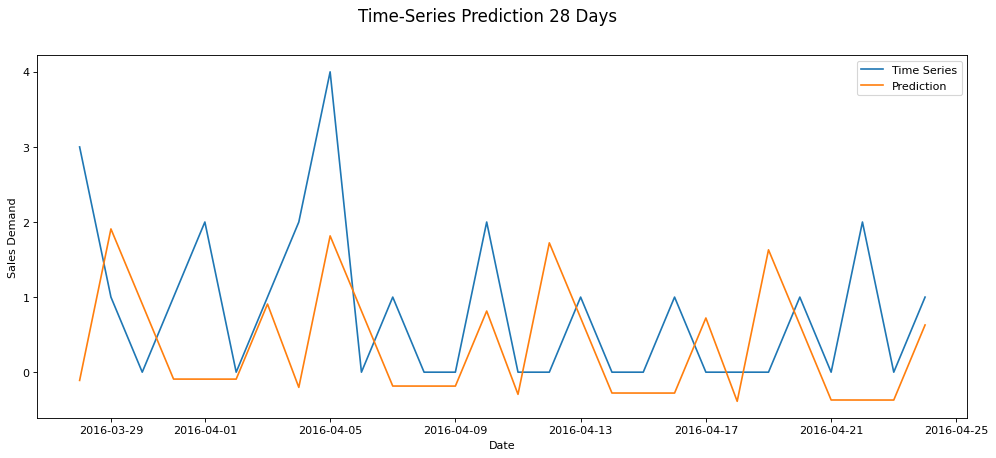

In [ ]:
## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[-28:]])
df_labels = pd.DataFrame(labels)
df_labels = df_labels.set_index([dates_list[-28:]])

# Plot 
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
#plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Time Series','Prediction'],fontsize = 10)
plt.suptitle('Time-Series Prediction 28 Days',fontsize = 15)
plt.xticks(fontsize=10 )
plt.yticks(fontsize=10 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 10)
plt.xlabel(xlabel = 'Date',fontsize = 10)
plt.show()

**RMSE**

In [ ]:
np.sqrt(((data_predict - labels) ** 2).mean())

1.361540129509652